In [1]:
import pandas as pd
import numpy as np
import ast
import os
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../..')
from modules.many_features import utils, constants
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

#### X_test

In [4]:
#df = pd.read_csv('data/anemia_synth_dataset_hb_some_nans.csv')
#df = pd.read_csv('data/noisy_data_uniform_all_30_08_22.csv')
# df = pd.read_csv('../../data/more_features/more_feats_correlated_noisy_6.csv')
# df = df.fillna(-1)
# class_dict = constants.CLASS_DICT
test_set = pd.read_csv('../../data/more_features/train_sets/test_set_constant.csv')
X_test = test_set.iloc[:, 0:-1]
y_test = test_set.iloc[:, -1]
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((14000, 17), (14000,))

In [5]:
# df['label'] = df['label'].replace(class_dict)
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
# test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
# # X_train, y_train = np.array(X_train), np.array(y_train)
# # X_test, y_test = np.array(X_test), np.array(y_test)
# test_set.shape

In [6]:
test_set.head()

,hemoglobin,ferritin,ret_count,segmented_neutrophils,tibc,mcv,serum_iron,rbc,gender,creatinine,cholestrol,copper,ethanol,folate,glucose,hematocrit,tsat,label
0,11.391136,-1.000000,1.504298,5.058881,467.197112,96.252926,217.860499,3.550376,1,-1.000000,36.703810,122.310168,49.897027,20.353251,-1.000000,34.173407,46.631388,6
1,10.355048,272.506966,-1.000000,0.000000,128.706486,101.912313,-1.000000,3.048223,1,-1.000000,-1.000000,-1.000000,29.327349,-1.000000,-1.000000,31.065144,-1.000000,2
2,11.159385,-1.000000,-1.000000,0.000000,-1.000000,103.395616,77.212369,3.237870,0,-1.000000,8.690122,65.554731,19.167967,7.239049,-1.000000,33.478155,-1.000000,2
3,8.179735,140.876632,5.484515,-1.000000,303.740826,99.877458,155.573175,2.456931,0,-1.000000,41.123526,119.433840,39.384848,6.394235,-1.000000,24.539204,51.219053,5
4,9.916825,-1.000000,3.909810,-1.000000,-1.000000,90.543986,189.347916,3.285748,0,1.501433,34.905667,59.177001,58.538524,22.843594,139.245204,29.750475,-1.000000,5


#### test_df

In [7]:
test_df =pd.read_csv('../../test_dfs/many_features/0.1/correlated/constant_test_set/test_df_noisy6_17000000.csv')
test_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
0,4.0,0.0,1.0,1.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",6.0,6.0
1,4.0,1.0,1.0,1.0,0.0,"['hemoglobin', 'mcv', 'segmented_neutrophils',...",2.0,2.0
2,4.0,2.0,1.0,1.0,0.0,"['hemoglobin', 'mcv', 'segmented_neutrophils',...",2.0,2.0
3,4.0,3.0,0.0,-1.0,1.0,"['hemoglobin', 'mcv', 'segmented_neutrophils',...",5.0,7.0
4,4.0,4.0,1.0,1.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Hemolytic ...",5.0,5.0


In [8]:
test_set.label.unique()

array([6, 2, 5, 0, 4, 3, 7, 1], dtype=int64)

In [9]:
len(test_df)

14000

In [10]:
test_df.y_pred.value_counts()

0.0    2014
1.0    1881
4.0    1820
2.0    1810
3.0    1771
6.0    1646
5.0    1594
7.0    1464
Name: y_pred, dtype: int64

In [11]:
def get_idx_df(target_df, idx_list):
    idx_df = target_df.iloc[idx_list]
    return idx_df

In [12]:
def get_distribution(df, feat): #df = anemia_test_df feat = where branching happens and whose value distribution we desire
    feat_dict = get_indices(df, feat)
    next_feat_df_dict = {}
    for i, next_feat in enumerate(list(feat_dict.keys())):
        next_feat_df = get_idx_df(test_set, feat_dict[next_feat])
        next_feat_df_dict[next_feat] = next_feat_df[feat]
    combined_df = pd.DataFrame(next_feat_df_dict)
    sns.set_style('dark')
    gfg = sns.boxplot(data = combined_df, palette='pastel')
    gfg.set(ylabel = feat, title = f'{feat} value distribution')
    plt.xticks(rotation=90)
    sns.despine()
    plt.show()    
    return combined_df

In [13]:
def get_indices(df, feat): #get indices n  df where feature is in pathway
    idx_dict = {}
    for i, row in df.iterrows():
        pathway = ast.literal_eval(row['trajectory'])
        if feat in pathway:
            feat_idx = pathway.index(feat)
            next_element = pathway[feat_idx+1]
            if next_element not in list(idx_dict.keys()):
                idx_dict[next_element] = [row.name]
            else:
                idx_dict[next_element].append(row.name)
    return idx_dict

#### delete from here

In [37]:
terminated_df = test_df[test_df.y_pred.isna()]

In [50]:
idx_dict = {}
feat = 'mcv'
count = 0
for i, row in terminated_df.iterrows():
    pathway = ast.literal_eval(row['trajectory'])
    if feat in pathway:
        feat_idx = pathway.index(feat)
        next_element = pathway[feat_idx+1]
        if next_element == feat:
            count+=1
count

0

In [44]:
feat_dict = get_indices(terminated_df, 'ret_count')
feat_dict.keys()

dict_keys(['segmented_neutrophils', 'ret_count', 'ferritin', 'tibc', 'mcv'])

In [49]:
len(feat_dict['mcv'])

2

#### end here

#### 0 - No anemia

In [14]:
no_num = 0
no_df = test_df[test_df.y_pred == no_num]
no_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
6,3.0,6.0,1.0,1.0,0.0,"['hemoglobin', 'gender', 'No anemia']",0.0,0.0
12,3.0,12.0,1.0,1.0,0.0,"['hemoglobin', 'gender', 'No anemia']",0.0,0.0
14,2.0,14.0,1.0,1.0,0.0,"['hemoglobin', 'No anemia']",0.0,0.0
17,3.0,17.0,1.0,1.0,0.0,"['hemoglobin', 'gender', 'No anemia']",0.0,0.0
21,3.0,21.0,1.0,1.0,0.0,"['hemoglobin', 'gender', 'No anemia']",0.0,0.0


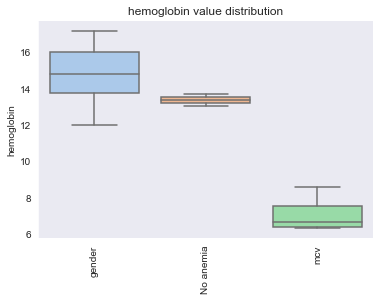

In [15]:
no_hb_distribution = get_distribution(no_df, 'hemoglobin')

In [18]:
#no_mcv_distribution = get_distribution(no_df, 'mcv')

#### 1- Hemolytic anemia

In [19]:
hemolytic_num = 0
hemolytic_df = test_df[test_df.y_pred == hemolytic_num]

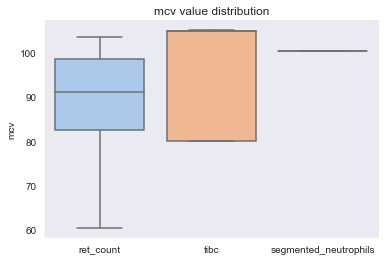

In [20]:
hemolytic_mcv_distribution = get_distribution(hemolytic_df, 'mcv')

In [21]:
#hemolytic_ferritin_distribution = get_distribution(hemolytic_df, 'ferritin')

#### 2 -  Aplastic anemia

In [24]:
aplastic_num = 3
aplastic_df = test_df[test_df.y_pred == aplastic_num]
aplastic_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
4,4.0,4.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",3.0,3.0
9,4.0,9.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",3.0,3.0
10,4.0,10.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",3.0,3.0
16,4.0,16.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",3.0,3.0
27,4.0,27.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'ret_count', 'Aplastic a...",3.0,3.0


In [25]:
len(aplastic_df)

3454

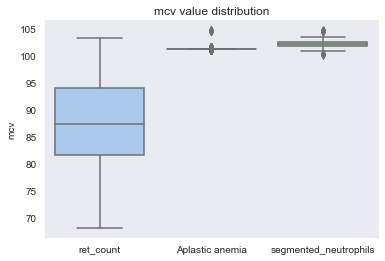

In [26]:
aplastic_mcv_distribution = get_distribution(aplastic_df, 'mcv')

#### 3 - Iron deficiency anemia

In [27]:
ida_num = 5
ida_df = test_df[test_df.y_pred == ida_num]
ida_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
437,5.0,437.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Iro...",5.0,5.0
635,5.0,635.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Iro...",5.0,5.0
766,5.0,766.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Iro...",5.0,5.0
776,5.0,776.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Iro...",5.0,5.0
1271,5.0,1271.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Iro...",5.0,5.0


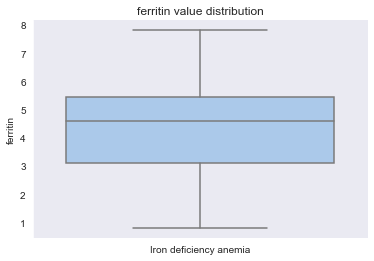

In [28]:
ida_mcv_distribution = get_distribution(ida_df, 'ferritin') #no branching

#### Vitamin B12/Folate deficiency anemia

In [30]:
vitamin_num = 4
vitamin_df = test_df[test_df.y_pred == vitamin_num]
vitamin_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
13,3.0,13.0,1.0,3.0,0.0,"['hemoglobin', 'mcv', 'Vitamin B12/Folate defi...",4.0,4.0
14,3.0,14.0,1.0,3.0,0.0,"['hemoglobin', 'mcv', 'Vitamin B12/Folate defi...",4.0,4.0
44,3.0,44.0,1.0,3.0,0.0,"['hemoglobin', 'mcv', 'Vitamin B12/Folate defi...",4.0,4.0
48,3.0,48.0,1.0,3.0,0.0,"['hemoglobin', 'mcv', 'Vitamin B12/Folate defi...",4.0,4.0
51,4.0,51.0,1.0,4.0,0.0,"['hemoglobin', 'mcv', 'segmented_neutrophils',...",4.0,4.0


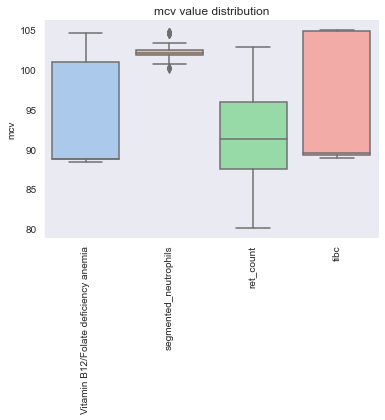

In [33]:
vitamin_mcv_distribution = get_distribution(vitamin_df, 'mcv')

#### Anemia of chronic disease

In [34]:
acd_num = 1
acd_df = test_df[test_df.y_pred == acd_num]
acd_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
1,5.0,1.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Ane...",1.0,1.0
11,5.0,11.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Ane...",1.0,1.0
15,5.0,15.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Ane...",1.0,1.0
18,5.0,18.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Ane...",1.0,1.0
20,5.0,20.0,1.0,5.0,0.0,"['hemoglobin', 'mcv', 'tibc', 'ferritin', 'Ane...",1.0,1.0


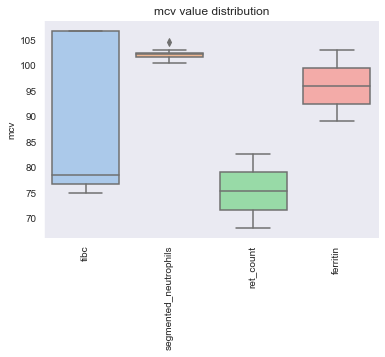

In [35]:
acd_mcv_distribution = get_distribution(acd_df, 'mcv')

#### terminated episodes

In [84]:
terminated_df = test_df[test_df.y_pred.isna()]
terminated_df.head()

,episode_length,index,is_success,reward,terminated,trajectory,y_actual,y_pred
30,8.0,30.0,0.0,-2.0,1.0,"['hemoglobin', 'mcv', 'segmented_neutrophils',...",1.0,NaN
81,8.0,81.0,0.0,0.0,1.0,"['hemoglobin', 'mcv', 'ferritin', 'ret_count',...",3.0,NaN
92,8.0,92.0,0.0,-2.0,1.0,"['hemoglobin', 'mcv', 'ret_count', 'ret_count'...",5.0,NaN
183,8.0,183.0,0.0,-2.0,1.0,"['hemoglobin', 'mcv', 'ret_count', 'ret_count'...",5.0,NaN
191,8.0,191.0,0.0,0.0,1.0,"['hemoglobin', 'mcv', 'ferritin', 'ret_count',...",3.0,NaN


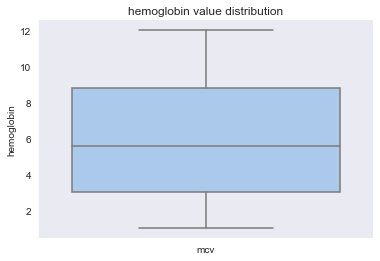

In [85]:
terminated_mcv_distribution = get_distribution(terminated_df, 'hemoglobin')

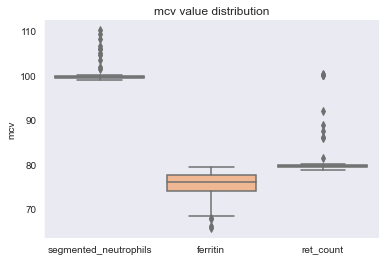

In [86]:
terminated_ret_distribution = get_distribution(terminated_df, 'mcv')

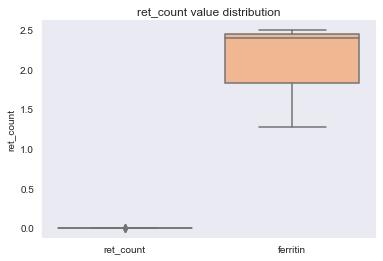

In [87]:
terminated_ret_distribution = get_distribution(terminated_df, 'ret_count')

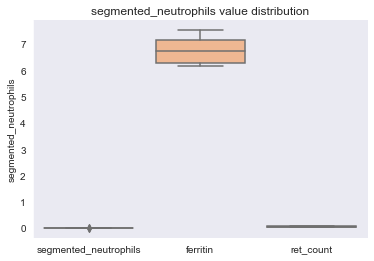

In [88]:
terminated_ret_distribution = get_distribution(terminated_df, 'segmented_neutrophils')

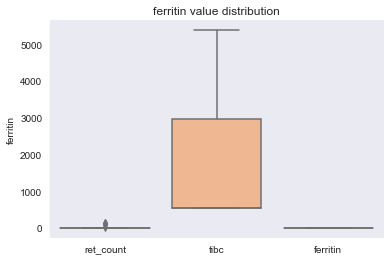

In [89]:
terminated_ferritin_distribution = get_distribution(terminated_df, 'ferritin')

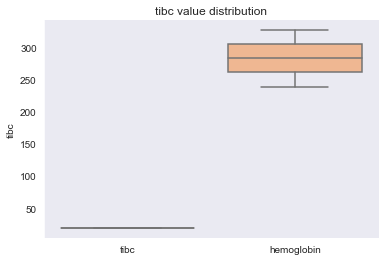

In [90]:
terminated_ferritin_distribution = get_distribution(terminated_df, 'tibc')